<a href="https://colab.research.google.com/github/Falconwatch/SexInRussiaStudy/blob/main/SexInRussia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Чтение данных

In [26]:
import pandas as pd
import numpy as np

In [8]:
data = pd.read_excel("Россия_в_постели_открытые_данные.xlsx", skiprows=2)

In [12]:
data.head(2)

,Пол,Возраст,Ориентация,Текущий статус,Наличие детей,Регион,Контрацепция,Частота мастурбации,Частота секса,Наличие секс-игрушек,Возраст первого секса,Привлекающие части тела,Сексуальные предпочтения,Сексуальные практики,Оценка сексуальной жизни,Оценка реализации сексуальных предпочтений
0,Мужской,18-24,Гетеро,Свободен / свободна,Нету,Алтайский край,Презервативы,Раз в несколько дней,Другое (частота менялась на протяжении года),Нет,16,"Женская грудь, Попа / Ягодицы, Живот / Торс, Л...","Связывание, Долгая прелюдия, Мастурбация партн...","Мастурбация партнёру, Порка, Долгая прелюдия, ...",7.0,5.0
1,Женский,18-24,Гетеро,В отношениях,Нету,Алтайский край,Презервативы,Раз в неделю,Раз в неделю,Нет,16,"Половой член, Руки, Спина","Подчинение (по отношению к партнёру), На публи...","Нежный секс, Массаж, 69, Минет, Фистинг, Нижне...",7.0,3.0


# Предобработка предпочтений и практик

In [133]:
#Список предпочтений
preferences = np.concatenate(data["Сексуальные предпочтения"].apply(lambda x: str(x).split(",")))
preferences = [p.lstrip().rstrip() for p in preferences]

#Считаем уникальные предпочтения и кладём в датафрейм
unique_values, unique_counts = np.unique(preferences, return_counts=True)
preferences_dataframe = pd.DataFrame(data = unique_values, columns = ["Предпочтение"])

preferences_dataframe["counts"] = unique_counts
preferences_dataframe.sort_values("counts", ascending=False, inplace=True)
preferences_dataframe.reset_index(inplace=True)
preferences_dataframe.drop(["index"], axis=1, inplace=True)

In [134]:
## Выделим самые популярные (или преставленные как варианты выбора)
##Криетрий популярности - более 0.1% человек

In [135]:
popular_preferences = preferences_dataframe[preferences_dataframe["counts"]>data.shape[0]/1000]

In [136]:
popular_preferences.shape

(40, 2)

In [173]:
def normalize_preferences(prefs):
  result = list()
  prefs_splited = prefs.split(",")
  prefs_splited = [p.lstrip().rstrip() for p in prefs_splited]
  for one_pref in prefs_splited:
    if one_pref in popular_preferences["Предпочтение"].values:
      result.append(one_pref)
    else:
      result.append("Иное")
  result = np.unique(np.sort(np.array(result)))
  return result

In [174]:
data["prefs_array"] = data["Сексуальные предпочтения"].apply(lambda x: normalize_preferences(str(x)))
data["practices_array"] = data["Сексуальные практики"].apply(lambda x: normalize_preferences(str(x)))

In [181]:
#Предпочитаю, но не практикую
data["prefs_but_bot_practice"] = data.apply(lambda x: list(set(x["prefs_array"]) - set(x["practices_array"])), axis=1)

#Практикую, но не хочу
data["practice_but_not_pref"] = data.apply(lambda x: list(set(x["practices_array"]) - set(x["prefs_array"])), axis=1)

# Анализ предпочтение и практик

In [194]:
#Что делают ради других
practice_but_not_pref_unique, practice_but_not_pref_unique_counts =  np.unique(np.concatenate(data["practice_but_not_pref"].values),return_counts=True)

practice_but_not_pref = pd.DataFrame(practice_but_not_pref_unique, columns = ["Не желаю, но делаю"])
practice_but_not_pref["count"] = practice_but_not_pref_unique_counts
practice_but_not_pref.sort_values("count", ascending=False, inplace=True,ignore_index=True)


practice_but_not_pref.head(20)

,"Не желаю, но делаю",count
0,Мастурбация партнёру,9652
1,Минет,7873
2,Нежный секс,6258
3,69,6056
4,Кунилингус,5361
5,Массаж,4854
6,Долгая прелюдия,4843
7,Нижнее белье,4327
8,Использование секс-игрушек,4140
9,Удушение,3335


In [176]:
def one_side_intersept(first, second):
  """Посчитаем вхожден"""

,Пол,Возраст,Ориентация,Текущий статус,Наличие детей,Регион,Контрацепция,Частота мастурбации,Частота секса,Наличие секс-игрушек,Возраст первого секса,Привлекающие части тела,Сексуальные предпочтения,Сексуальные практики,Оценка сексуальной жизни,Оценка реализации сексуальных предпочтений,prefs_array,practices_array
0,Мужской,18-24,Гетеро,Свободен / свободна,Нету,Алтайский край,Презервативы,Раз в несколько дней,Другое (частота менялась на протяжении года),Нет,16,"Женская грудь, Попа / Ягодицы, Живот / Торс, Л...","Связывание, Долгая прелюдия, Мастурбация партн...","Мастурбация партнёру, Порка, Долгая прелюдия, ...",7.0,5.0,"[69, Долгая прелюдия, Доминирование (по отноше...","[69, Долгая прелюдия, Доминирование (по отноше..."
1,Женский,18-24,Гетеро,В отношениях,Нету,Алтайский край,Презервативы,Раз в неделю,Раз в неделю,Нет,16,"Половой член, Руки, Спина","Подчинение (по отношению к партнёру), На публи...","Нежный секс, Массаж, 69, Минет, Фистинг, Нижне...",7.0,3.0,"[БДСМ, Двойное проникновение, Доминирование (п...","[69, Массаж, Минет, Нежный секс, Нижнее белье,..."
2,Женский,18-24,Гетеро,В отношениях,Нет,Алтайский край,"Гормональный метод (таблетки, инъекции, кольца...",Раз в несколько месяцев,Раз в несколько недель,Нет,17,"Шея, Живот / Торс, Мужская грудь","Фистинг, Кунилингус, Жесткий секс, Фингеринг, ...","Подчинение (по отношению к партнёру), Фистинг,...",6.0,4.0,"[69, Жесткий секс, Кунилингус, Удушение, Финге...","[Долгая прелюдия, Жесткий секс, Кунилингус, Ма..."
3,Женский,18-24,Би,В отношениях,Нет,Алтайский край,Прерванный половой акт,Раз в несколько дней,Раз в несколько недель,Нет,17,"Попа / Ягодицы, Губы, Плечи, Пальцы рук, Волос...","Грязные разговоры, Долгая прелюдия, Мастурбаци...",Мастурбация партнёру,5.0,2.0,"[Грязные разговоры, Долгая прелюдия, Кунилингу...",[Мастурбация партнёру]
4,Женский,18-24,Гетеро,Свободен / свободна,Нет,Алтайский край,"Гормональный метод (таблетки, инъекции, кольца...",Раз в несколько дней,Другое (частота менялась на протяжении года),Да,15,"Спина, Ноги, Глаза, Плечи, Половой член, Шея, ...","Секс втроём, Страпон, Доминирование (по отноше...","Порка, Доминирование (по отношению к партнёру)...",7.0,4.0,"[БДСМ, Групповой секс, Двойное проникновение, ...","[69, Анальный секс, БДСМ, Грязные разговоры, Д..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33618,Женский,18-24,Гетеро,Свободен / свободна,Нет,Ярославская область,Презервативы,Раз в неделю,Раз в несколько месяцев,Нет,18,"Соски, Попа / Ягодицы, Глаза, Спина, Мужская г...","Жесткий секс, Удушение, Доминирование (по отно...","Жесткий секс, Мастурбация партнёру, Минет",3.0,3.0,"[Доминирование (по отношению к партнёру), Жест...","[Жесткий секс, Мастурбация партнёру, Минет]"
33619,Женский,18-24,Гетеро,В отношениях,Нет,Ярославская область,Презервативы,Раз в несколько недель,Другое (частота менялась на протяжении года),Нет,15,"Шея, Пальцы рук, Руки, Живот / Торс, Половой ч...","Анальный секс, Секс втроём, Страпон, Жесткий с...","Нежный секс, Порка, 69, Мастурбация партнёру, ...",8.0,4.0,"[Анальный секс, Доминирование (по отношению к ...","[69, Долгая прелюдия, Жесткий секс, Кунилингус..."
33620,Женский,18-24,Гетеро,Свободен / свободна,Нет,Ярославская область,Презервативы,Раз в месяц,Раз в год,Нет,17,"Волосы, Живот / Торс, Лицо, Попа / Ягодицы, Гл...","БДСМ, Связывание, Удушение, Нижнее белье, Долг...","Доминирование (по отношению к партнёру), Минет...",4.0,4.0,"[БДСМ, Долгая прелюдия, Нижнее белье, Связыван...","[Доминирование (по отношению к партнёру), Мине..."
33621,Мужской,25-34,Гетеро,Женат / замужем,Нет,Ярославская область,Прерванный половой акт,Раз в несколько дней,Раз в несколько дней,Да,18,"Шея, Женская грудь, Попа / Ягодицы, Спина, Ног...","Грязные разговоры, 69, Жесткий секс, Использов...","Кунилингус, Анальный секс, Минет, 69, Жесткий ...",9.0,3.0,"[69, Анальный секс, Групповой секс, Грязные ра...","[69, Анальный секс, Долгая прелюдия, Жесткий с..."


In [ ]:
data[""]

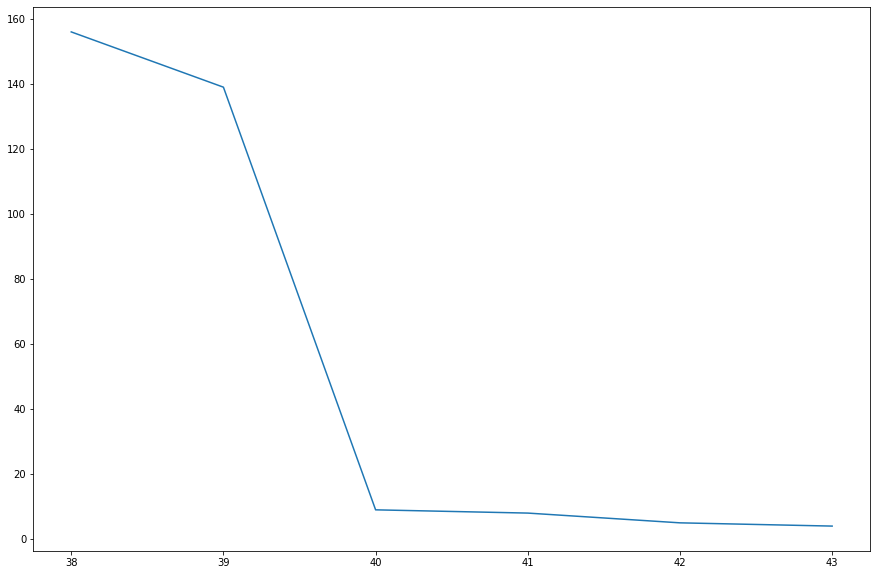

In [129]:
preferences_dataframe["counts"][38:44].plot(figsize=[15,10])

In [29]:
set(np.concatenate(preferences.values))

{' ',
 '  неопытность',
 ' "погоне"',
 ' 69',
 ' ABDL',
 ' ASMR',
 ' ATM',
 ' Ball play',
 ' CBT (пытки члена) ',
 ' CBT в разумных пределах',
 ' CFNM',
 ' Cowgirl Twerk',
 ' FFM',
 ' Facial',
 ' Gentle femdom',
 ' Glory hole',
 ' Knife play',
 ' MILF',
 ' Nipple play',
 ' Orgasm Denial',
 ' POV ',
 ' Petplay ',
 ' Praise kink',
 ' Primal play / predator (отыгрывание "животного" поведения во время прелюдии и/или секса',
 ' Puppy',
 ' Role Reversal лайфстайл (я в доминирующей/"верхней" роли)',
 ' Size difference',
 ' Sleepy',
 ' Stuck fetish',
 ' Tickling',
 ' Vore',
 ' balljob',
 ' bodywriting',
 ' cumcontrol',
 ' curvy/chubby (но не bbw)',
 ' deepthroat',
 ' edging ',
 ' facial',
 ' fight sex',
 ' foster siblings',
 ' glory hole',
 ' gloryhole',
 ' joi',
 ' knife play',
 ' knife-play',
 ' mammy kink',
 ' milf',
 ' muscle worship  (хз',
 ' nipple play',
 ' pegging',
 ' pet ',
 ' praise kink',
 ' primal(pray)',
 ' primalsexuality',
 ' titfuck',
 ' wax/fire play',
 ' wedgie',
 ' «изнаsил